# Predicting Forest Fires in Algeria

## Introduction

Climate change has drastically increased the risk and extent of forest fires in several places around the world. Forest fires have numerous devastating effects such as the destruction of wildlife habitat and animal life, toxic gas emission to the atmosphere, infrastructure damage and could potentially cost human lives in the wake of a fire. Recognizing the potentially catastrophic effects of forest fires, it is vital to have some sort of early warning system that can help governmental agencies in forecasting forest fires.

<p float="left">
  <img src = "https://www.lifeinsuranceinternational.com/wp-content/uploads/sites/8/2019/02/shutterstock_710588224.jpg" width = "300"/>
  <img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQkiv3dvAtycEW-ZvEomKQXvL38bNuSKx1sOQ&usqp=CAU" width = "350" height = 265/>
  <img src = "https://i.natgeofe.com/n/77462492-ea41-41fe-9c07-296dc330181f/80133.jpg" width = "260"/>
</p>

This prompts us to question: *Can we predict the occurence of forest fires base on certain weather metrics? If so, what are the metrics (variables) that create the most optimal predictive model?*
With that motivation in mind, this project aims to develop a k-nearest neighbours machine learning model that can predict whether or not a forest fire will occur based on various weather metrics. Our dataset is obtained from <https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++#>. This is a grouped dataset that contains observations from two different regions of Algeria, namely the Bejaia region in the northeast and the Siddi Bel-Abbes region in the northwest.

The dataset contains 14 columns:
* Day (day)
* Month (month): June to September
* Year (year): 2012
* Temperature: maximum temperature at noon, in degree Celsius (range: 22 -40)
* Relative humidity (RH): relative humidity in % (range: 21 - 90)
* Windspeed (Ws): in speed in km/h (range: 6 - 29)
* Rain amount (Rain): rain amount in a day, in milimeters (mm) (range: 0 - 16.8)
* Fine Fuel Moisture Code (FFMC) index from the FWI system (range: 28.6 - 92.5)
* Duff Moisture Code (DMC) index from the FWI system (range: 1.1 - 65.9)
* Drought Code (DC) index from the FWI system (range: 7 - 220.4)
* Initial Spread Index (ISI) index from the FWI system (range: 0 - 18.5)
* Buildup Index (BUI) index from the FWI system (range: 1.1 - 68)
* Fire Weather Index (FWI) Index (range: 0 - 31.1)
* Classes: fire/not fire

We will choose the predictors through the process of *forward selection* to obtain the combination of variables that yield the best prediction accuracy.

## Methods & Results

### Overview of our Methodology

The Algerian Forest Fire dataset provides us with two different regions to account for: Bejaia and Sidi-Bel Abbes. Our team decided to combine the two regions to create more comprehensive data to better equip our model. Here is an overview of our data analysis methodology (detailed explanation will be presented at each step):
<ol>
<li>Reading & Wrangling: read and wrangle the dataset into one tidy combined dataset of the two regions</li>
<li>Train/Test split: spliting the tidy dataframe into a training set and testing set, then summarizing the sameple statistics of the training data</li>
<li>Predictor variables selection: find the combination of predictors that yield relatively highest prediction accuracy, by using forward selection.</li>
<li>K-Nearest Neighbor classification: model tuning with cross-valiation, reconfigure and re-train the model with the best K parameter, predict the test set for final model accuracy validation</li>
<li>Results and Conclusion</li>    
</ol>

### Loading relevant libraries

In [26]:
library(tidyverse)
library(tidymodels)
library(forcats)
library(RColorBrewer)
library(repr)
library(ggplot2)
library(knitr)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

### Reading & Wrangling our dataset from the web into R

* Due to there being 2 datasets in a single .csv file, we read them separately and then merged both of them into a single dataframe called "forest_fires".
* The dataset for <strong>Bejaia</strong> region has 1 line of metadata and a total of 122 rows therefore <code>skip = 1</code> and <code>n_max = 122</code> were used as arguments.
* The dataset for <strong>Sidi-Bel</strong> region started after 126 rows of the csv file therefore <code>skip = 126</code> was used as an argument.
* Since there was a missing value in one of the rows, the <code>na.omit()</code> function was used to get rid of that row.  
* The columns which had numerical values but were of a different type due to misinputs were converted back into numerical variables using <code>as.numeric()</code>.
* The rows of both the regions were combined to form one dataset using <code>rbind()</code>.
* The Class column will be our target variable for this analysis therefore it was converted into a factor variable using <code>as_factor()</code>.
* The region column was created to identify which observation belonged to which region. It was binded to the dataset using <code>cbind()</code> where 122 of the observations were of the <strong>Bejaia</strong> region and 121 observations were of the <strong>Sidi-Bel</strong> region.
* The resulting dataset is our wrangled <code>forest_fires</code> dataset with **243** useful observations.

In [27]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

Bej_data <- read_csv(url, skip = 1, n_max = 122)

SB_data <- read_csv(url, skip = 126) %>% 
    na.omit() %>% 
    mutate(DC = as.numeric(DC),
           FWI = as.numeric(FWI))

forest_fires <- rbind(Bej_data, SB_data) %>% 
    mutate(day = as.numeric(day),
           month = as.numeric(month),
           Classes = as_factor(Classes))

forest_fires <- cbind(region = (c(rep("Bejaia", 122), rep("Sidi-Bel Abbes", 121))), forest_fires)

forest_fires

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_character(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“1 parsing failure.
row col   expected     actual                                                                                                       file
 44  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-lear

region,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Bejaia,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
Bejaia,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
Bejaia,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Sidi-Bel Abbes,28,9,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
Sidi-Bel Abbes,29,9,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire
Sidi-Bel Abbes,30,9,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire


### Summarizing the Training Data

* Base on our data wrangling step, we have a total of **243** usable observations.
* Thus, we have make a random split of **0.75**, which means 75% of the data is splitted into the training set and the remaining 25% into the test set to ensure that we have an adequate amount of observations for training and evaluating the prediction accuracy of our model.
* We also used set.seed() for reproducible results as initial_split randomly samples from the dataframe.

In [28]:
set.seed(1234)
ff_split <- initial_split(forest_fires, prop = 0.75, strata = Classes)
ff_train <- training(ff_split)
ff_test <- testing(ff_split)

* Now we begin exploratory data analysis by summarizing the data into different types of tables.
* In the code block below, the table reports the number of observations in each class (not fire or fire).

In [29]:
n_per_class <- ff_train %>% 
    group_by(Classes) %>% 
    summarize(n = n())

n_per_class

`summarise()` ungrouping output (override with `.groups` argument)



Classes,n
<fct>,<int>
not fire,80
fire,103


* In the code block below, the table reports the number of observations in each class for each region.

In [30]:
n_per_class_region <- ff_train %>% 
    group_by(region, Classes) %>% 
    summarize(n = n())

n_per_class_region

`summarise()` regrouping output by 'region' (override with `.groups` argument)



region,Classes,n
<chr>,<fct>,<int>
Bejaia,not fire,45
Bejaia,fire,49
Sidi-Bel Abbes,not fire,35
Sidi-Bel Abbes,fire,54


* In the code block below, the table reports the means of the predictor variables for all regions.

In [31]:
avg_pred_vals <- ff_train %>% 
    select(-day, -month, -year, -Classes, -region) %>% 
    map_df(mean, na.rm = TRUE)

avg_pred_vals

Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
32.23497,62.43716,15.55738,0.6612022,78.22131,14.15027,48.95355,4.653005,16.21093,6.839891


* In the code block below, the two tables report the means of the predictor variables for the each region.

In [32]:
bej_avg_pred_vals <- ff_train %>% 
    filter(region == "Bejaia") %>%
    select(-day, -month, -year, -Classes) %>% 
    map_df(mean, na.rm = TRUE) %>% 
    mutate(region = c("Bejaia"))

sid_avg_pred_vals <- ff_train %>% 
    filter(region == "Sidi-Bel Abbes") %>%
    select(-day, -month, -year, -Classes) %>% 
    map_df(mean, na.rm = TRUE) %>% 
    mutate(region = c("Sidi-Bel Abbes"))

bej_avg_pred_vals
sid_avg_pred_vals

Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


region,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bejaia,31.57447,67.59574,16.1383,0.6361702,76.09681,12.66277,54.82447,3.847872,15.87766,5.844681


region,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sidi-Bel Abbes,32.93258,56.98876,14.94382,0.6876404,80.46517,15.72135,42.75281,5.503371,16.56292,7.891011


## Expected Outcomes and Significance

* We expect to produce a decently accurate k-nearest-neighbour model to predict whether a forest fire would occur based on our chosen weather metrics as predictors. Furthermore, our aim is to make the prediction data useful with regards to reducing the number of Forest Fires within the Algerian region by learning how each of the selected predictor variables interacts with one another; thus, minimizing the forest fire that can be predicted beforehand. Additionally, this analysis could potentially help us to answer future questions concerning the role of climate and environmental variation that affects our ecological succession.
* A successful completion of this model could help the authorities in predicting forest fires, preventing damages to human lives, infrastructure and the environment as a whole. In addition, through this project, we can obtain more insight into whether certain weather metrics/conditions are significant in successfully predicting the occurrence of forest fires.
* Some future questions and researches that our analysis could lead to are as follows:
<ol>
<li>Can we use a better algorithm to predict forest fire? If so, which one would be the best for this application?</li>
<li>Can a model trained with data from a country/climate region predict whether forest fires would occur if presented with an observation from another country/climate region? In other words, can we extrapolate?</li>
<li>Are the current weather metrics good in predicting forest fires (Fire Weather Index System)? Can we develop a better forest fire system or better ways to collect the data/metrics?</li>
</ol>

### Predictor Variable Selection

* We begin our data analysis by tuning our classifier to choose which variables from our data will be treated as predictor variables. 
* We want to find out if there are any irrelevant predictors in our data set which will negatively impact our classifier. 
* To ensure that the choice of which variables to include as predictors is part of tuning our classifier, we conduct this on our __training set__.
* In order to the best predictors, we will use the _forward selection method_.
<ol>
<li>start with a model having no predictors</li>
<li>run the following 3 steps until you run out of predictors:</li>
    <ol>
        <li>for each unused predictor, add it to the model to form a candidate model</li>
        <li>tune all of the candidate models</li>
        <li>update the model to be the candidate model with the highest cross-validation accuracy</li>
    </ol>
<li>select the model that provides the best trade-off between accuracy and simplicity</li>
</ol>
  
  
__Note: We will be selecting the 4 best predictors according to this method in our code so that it runs relatively faster than the code for 10 predictors. This is done to save time however we will also be providing the resulting accuracy table for all predictors in the model after.__

In [33]:
set.seed(1)

ff_subset1 <- ff_train %>% select(FFMC,ISI,Rain,FWI,Classes)
names1 <- colnames(ff_subset1 %>% select(-Classes))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
ff_vfold <- vfold_cv(ff_subset1, v = 5, strata = Classes)

# store the total number of predictors
n_total <- length(names1)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names1)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names1[[j]])
        model_string <- paste("Classes", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        ff_recipe <- recipe(as.formula(model_string), data = ff_subset1) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(ff_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = ff_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])
    selected <- c(selected, names1[[jstar]])
    names1 <- names1[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Classes ~ FFMC,0.9834835
2,Classes ~ FFMC+ISI,0.9779279
3,Classes ~ FFMC+ISI+Rain,0.9782282
4,Classes ~ FFMC+ISI+Rain+FWI,0.9728228


* The table below represents the models and their respective accuracies for __ALL__ predictor variables.
* Naturally, we choose the model which yields the highest accuracy. It is observed that the model of size 1 and the model of size 3 have the highest accuracies. However, since we do not want a model with only one predictor variable, we select the next best model which is the model with the predictor variables: __FFMC, ISI and RAIN__.

| size|model_string                                             |  accuracy|
|----:|:--------------------------------------------------------|---------:|
|    1|Classes ~ FFMC                                           | 0.9834835|
|    2|Classes ~ FFMC+ISI                                       | 0.9779279|
|    3|Classes ~ FFMC+ISI+Rain                                  | 0.9782282|
|    4|Classes ~ FFMC+ISI+Rain+FWI                              | 0.9728228|
|    5|Classes ~ FFMC+ISI+Rain+FWI+DMC                          | 0.9728228|
|    6|Classes ~ FFMC+ISI+Rain+FWI+DMC+DC                       | 0.9674174|
|    7|Classes ~ FFMC+ISI+Rain+FWI+DMC+DC+BUI                   | 0.9674174|
|    8|Classes ~ FFMC+ISI+Rain+FWI+DMC+DC+BUI+Ws                | 0.9507508|
|    9|Classes ~ FFMC+ISI+Rain+FWI+DMC+DC+BUI+Ws+RH             | 0.9510511|
|   10|Classes ~ FFMC+ISI+Rain+FWI+DMC+DC+BUI+Ws+RH+Temperature | 0.9345345|

### Visualizing the best predictors in the Training Data

* The histograms depicted below represent the distributions of each predictor variable.
* We use histograms because we are creating a distribution visualization for **numerical** data.
* Each histogram shows the distribution of each predictors, with different colors for each region.

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”


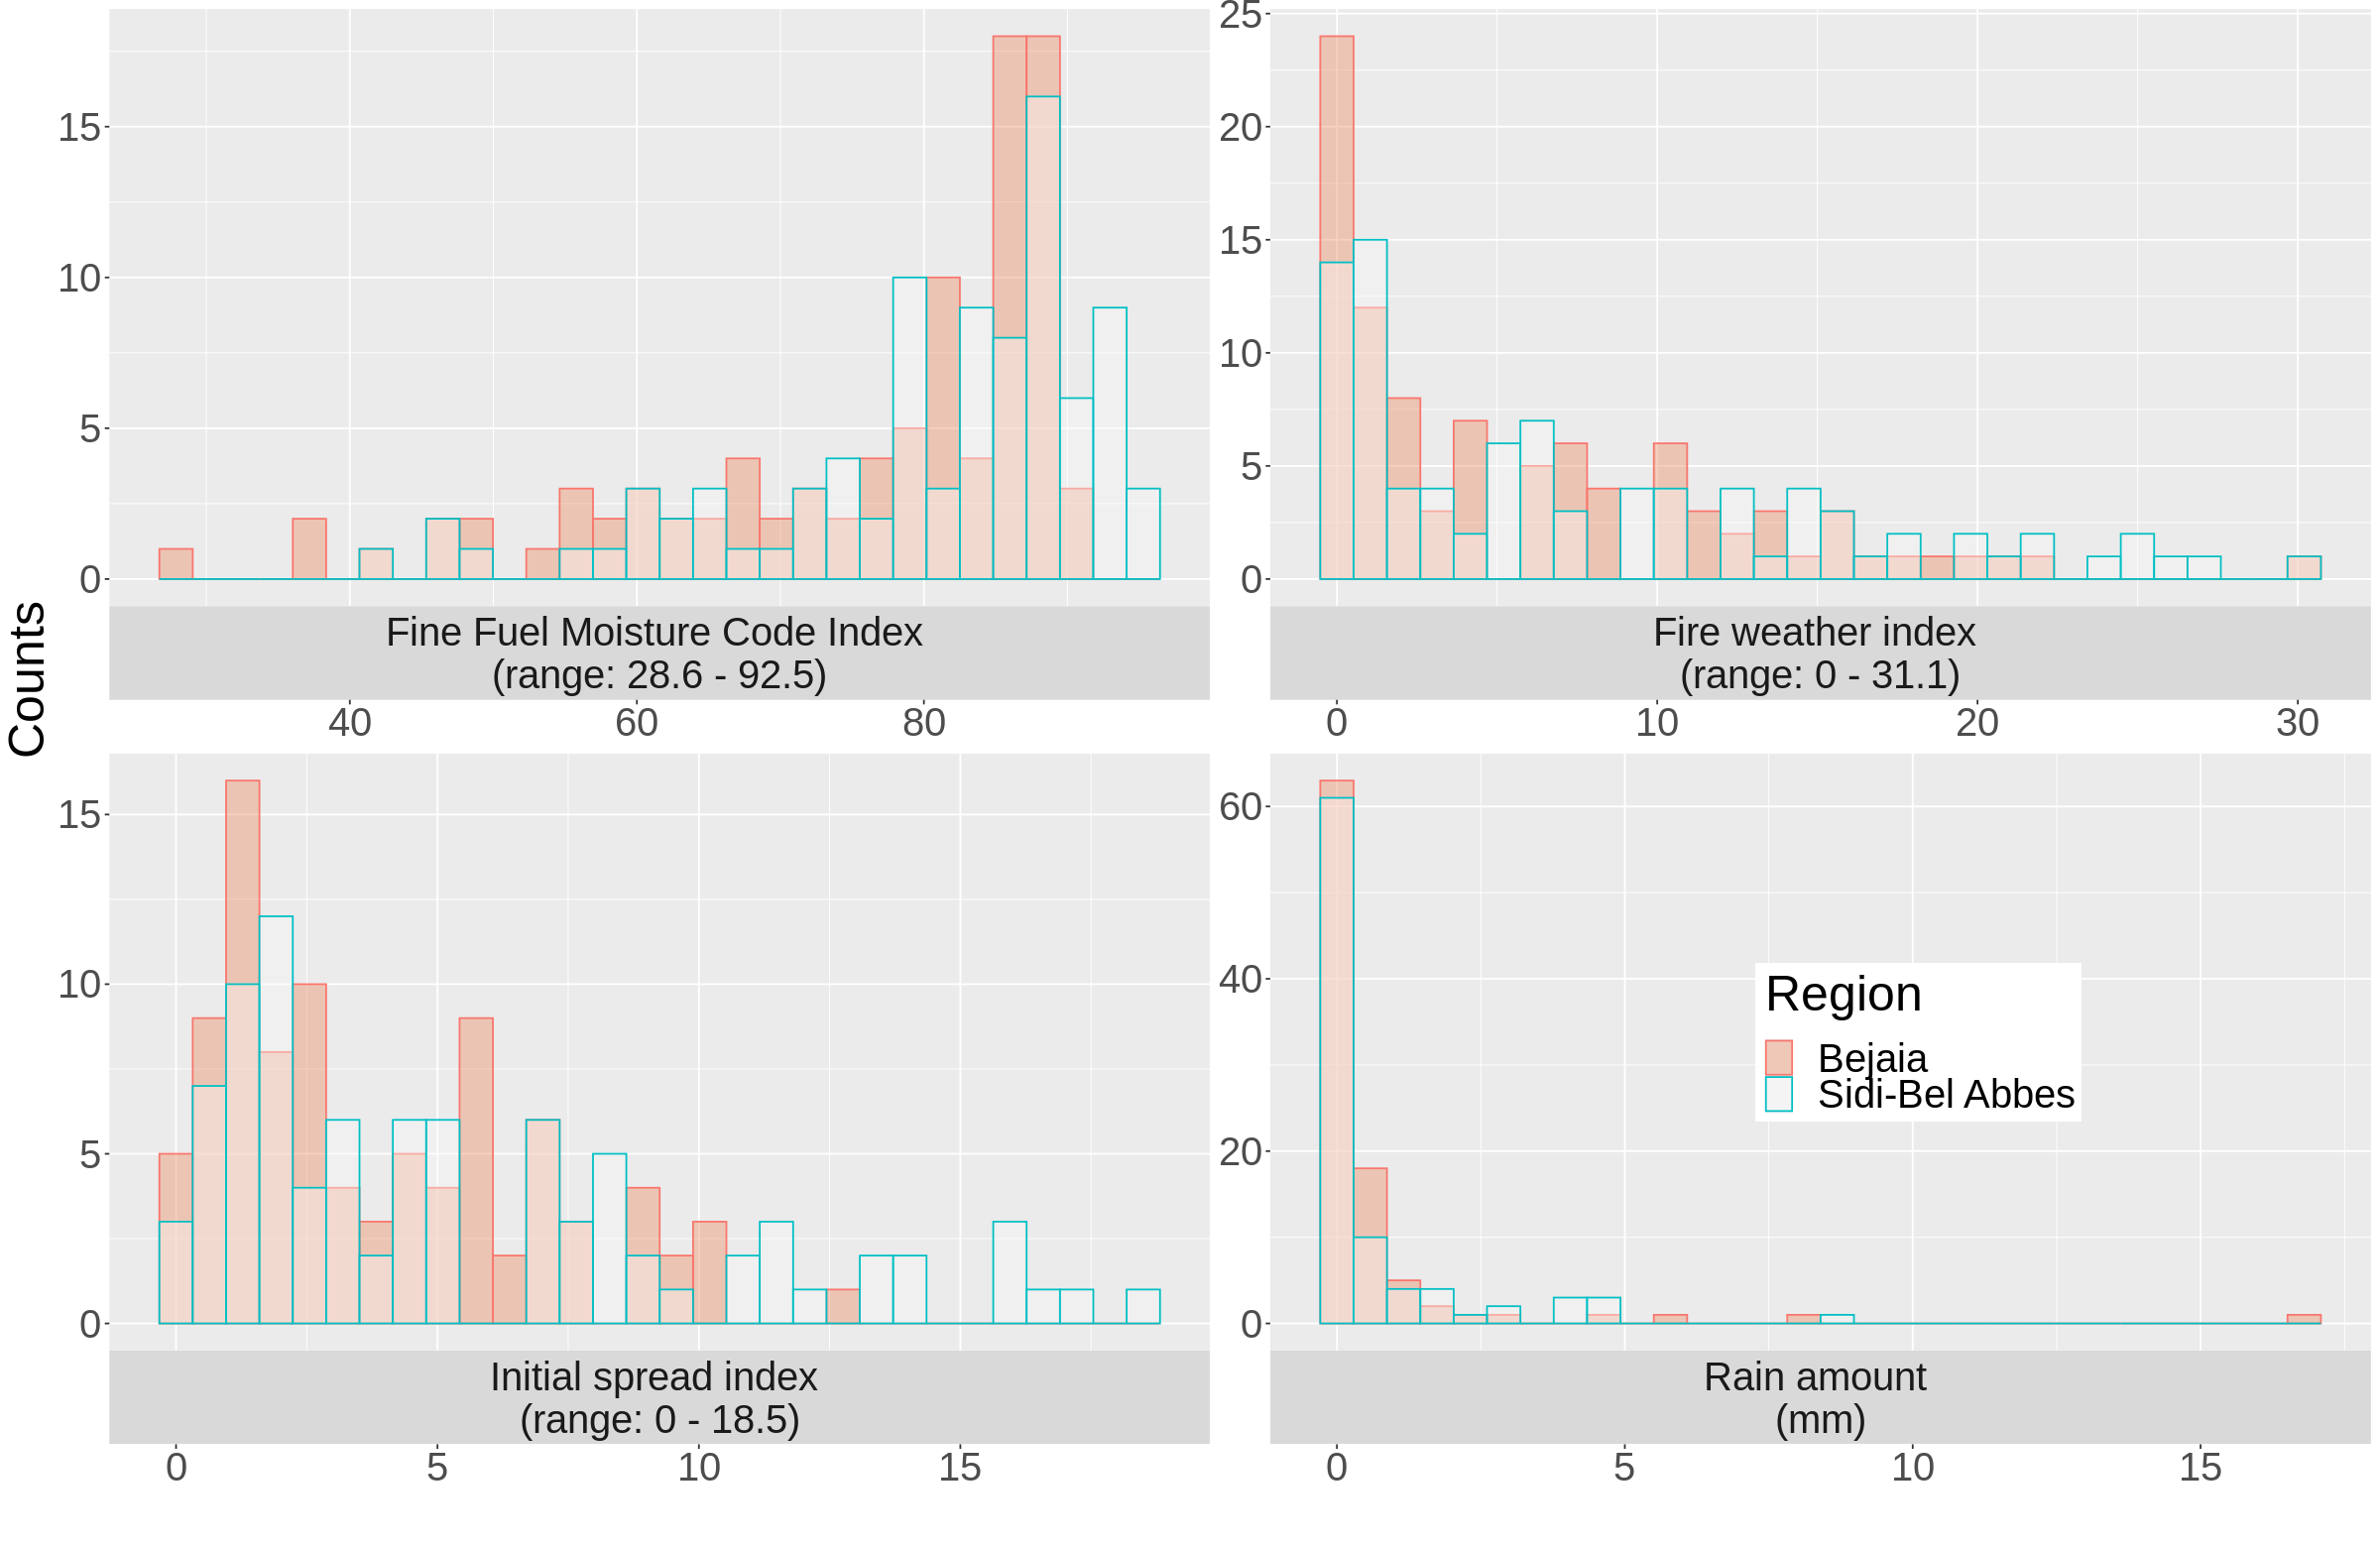

In [34]:
options(repr.plot.width = 20, repr.plot.height = 13)

a <- ff_train %>%
    select(region,FFMC,ISI,Rain,FWI,Classes) %>% 
    pivot_longer(cols = FFMC:FWI,
                 names_to = "predictors",
                 values_to = "values")

predictor_labels <- c(FFMC = "Fine Fuel Moisture Code Index \n(range: 28.6 - 92.5)",
                   ISI = "Initial spread index \n(range: 0 - 18.5)",
                   Rain = "Rain amount \n(mm)",
                   FWI = "Fire weather index \n(range: 0 - 31.1)")

distribution_plot <- a %>%
    ggplot(aes(x = values, fill = region, colour = region)) + 
    geom_histogram(alpha = 0.4, position = 'identity', bins = 30) +
    labs(x = "", y = "Counts", fill = "Region", colour = "Region") +
    facet_wrap(vars(predictors), 
               scales = "free",
               switch = "x",
               labeller = labeller(predictors = predictor_labels)) +
    theme(strip.text.y.left = element_text(angle = 0),
          legend.position = c(0.80, 0.23),
          text = element_text(size = 30)) +
    scale_fill_brewer(palette = "RdBu") # To see more colorblind friendly pallete: display.brewer.all(colorblindFriendly = T)


distribution_plot

Visualization analysis:
* FFMC: left-skewed, most observations for the two regions separately or combined together have very high FFMC value
* ISI: Slightly right-skewed, most observations from the two regions separately or combined have medium to low ISI value
* Rain amount: extremly right-skewed, most observations from the two regions separately or combined have very little to no rain
* Overall the two regions share very similar frequency distributions for each of the predictors.

### Tuning our K-NN Classifier

* We now conduct the K-NN classification analysis on our dataset with predictors: __FFMC, ISI and Rain__.
* To do this, we:
<ol>
    <li>Define a recipe with the predictors: <strong>FFMC, ISI and Rain</strong>. We further scale and center our predictors.</li>
    <li>Define the specification for our k-nn model. We use <code>tune()</code> for the neighbours argument because we will first tune our model to choose the best k-value for our model.</li>
    <li>Perform cross-validation with <strong>5</strong> folds. This is because our dataset is not too large so 20% of the data for validation is considerably accurate. </li>
    <li>Create a workflow adding the recipe and the model and applying the <code>tune_grid()</code> function for cross-validation. We then collect the resulting accuracies with the <code>collect_metrics()</code> function.</li>
    <li>Finally, we plot the accuracies against the neighbours in order to visualize the most stable k nearest neighbour. It is observed and highlighted that <strong>k = 13</strong> is the most optimal value. This is because it is relatively higher than most other neighbours and does not immediately fall as we increase or decrease the neighbour by 1.</li>
</ol>

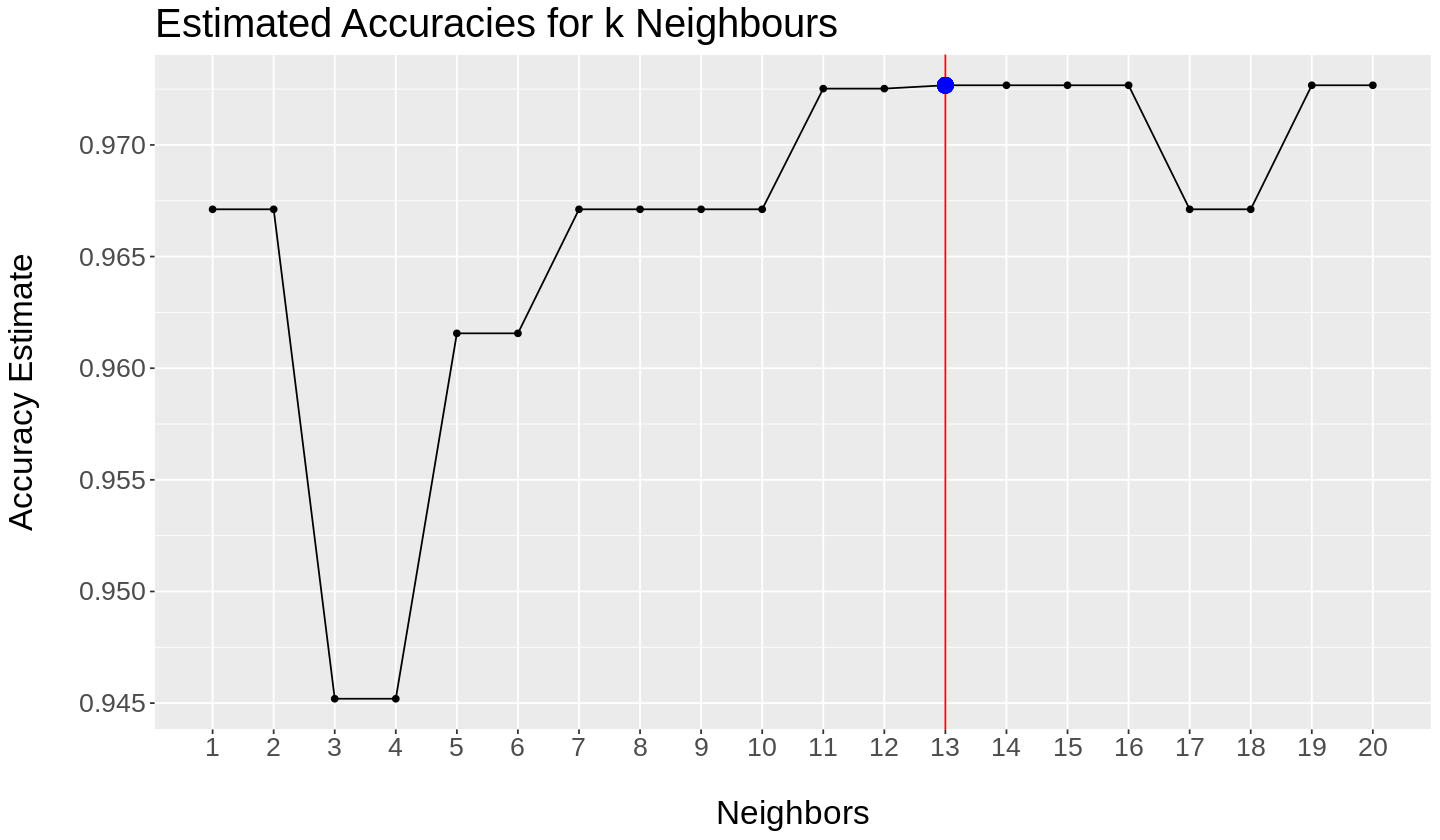

In [35]:
set.seed(1)

ff_recipe <- recipe(Classes ~ FFMC + ISI + Rain, data = ff_train) %>% 
    step_scale(all_predictors()) %>% 
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

ff_vfold <- vfold_cv(ff_train, v = 5, strata = Classes)
gridvals <- tibble(neighbors = seq(1, 20))

ff_results <- workflow() %>% 
    add_recipe(ff_recipe) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = ff_vfold, grid = gridvals) %>% 
    collect_metrics() %>% 
    filter(.metric == "accuracy")

options(repr.plot.width = 12, repr.plot.height = 7)

ky <- ff_results %>% filter(neighbors == 13) %>% select(mean) %>% pull()

cross_val_plot <- ff_results %>% 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 13, colour = "red") +
    geom_point(aes(x=13, y= ky), size = 4, colour = "blue") +
    labs(x = "\nNeighbors", y = "Accuracy Estimate\n", title = "Estimated Accuracies for k Neighbours") +
    scale_x_continuous(limits = c(1, 20), breaks = seq(1, 20), minor_breaks = seq(1, 20, 1)) +
    theme(text = element_text(size = 20))

cross_val_plot

# This visualization suggests that K=13 provides the highest and the most omptimal accuracy.

### KNN Classification

* Now, we conduct our KNN classification on the test set with the help of our trained model.
* It is observed in the table below that the accuracy of our predictions was 98% which is very high.
* We can also see that only one of our predictions was wrong.
* In order to visualize the results, we also created a confusion matrix to signify the accuracy of our results. It can be deduced from this matrix that a total of 59 out of the 60 predictions were true. Only in one case where the actual class was "fire" did our model falsely predict "not fire".

In [36]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

ff_fit <- workflow() %>%
  add_recipe(ff_recipe) %>%
  add_model(knn_best_spec) %>%
  fit(data = ff_train)

ff_predictions <- predict(ff_fit, ff_test) %>% 
    bind_cols(ff_test)

ff_predictions %>% 
    metrics(truth = Classes, estimate = .pred_class) %>% 
    select(.metric, .estimate) %>% 
    head(1)

ff_cm <- ff_predictions %>% 
    conf_mat(truth = Classes, estimate = .pred_class)

.metric,.estimate
<chr>,<dbl>
accuracy,0.9833333


Warning message in pal_name(palette, type):
“Unknown palette Mint”
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



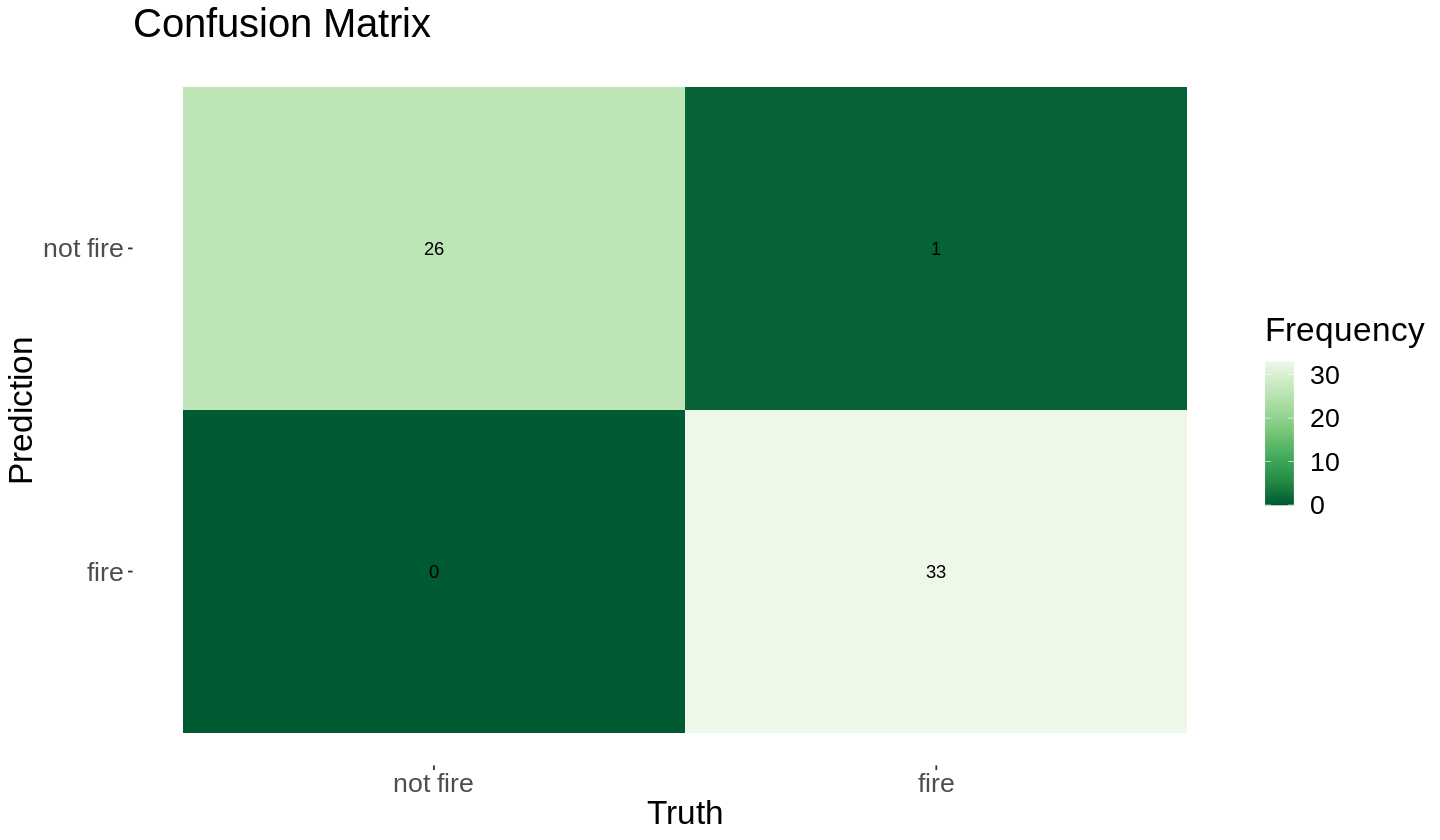

In [37]:
autoplot(ff_cm, type = "heatmap") +
scale_fill_distiller(palette = "Mint", name = "Frequency") + #color blind friendly
ggtitle("Confusion Matrix") +
theme(legend.position = "right", text = element_text(size = 20))